In [23]:
from sklearn import datasets
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import StratifiedKFold
from statistics import mean


from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from os.path import isfile, join
import matplotlib.pyplot as plt
import tensorflow as tf
from os import listdir
import pandas as pd
import numpy as np
import tensorflow
from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers.legacy import Adam

from keras.applications import VGG16
from keras.layers import GlobalMaxPooling2D, Dense, Dropout
from keras.models import Model

In [24]:
def loadModel(nameModel):
    json_file = open( nameModel + ".json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    cnn = model_from_json(loaded_model_json)
    print(cnn)
    cnn.load_weights(nameModel + ".h5")
    print("Loaded model from disk")
    return cnn

In [25]:
def prediction(model, pathBatch, classValue, classes):
    class_test    = [f for f in listdir(pathBatch) if isfile(join(pathBatch, f))]
    roundedValues = np.zeros(len(class_test))
    realValues    = np.zeros(len(class_test))
    wrongPaths    = []
    wrongErrors   = []


    for i in range(len(class_test)):
        if not (".DS_Store" in class_test[i]):
            path = pathBatch + "/" + class_test[i]
            test_image = tf.keras.preprocessing.image.load_img(path, target_size=(64,64))
            test_image = tf.keras.preprocessing.image.img_to_array(test_image)
            test_image = np.expand_dims(test_image, axis=0)
            result     = model.predict(test_image/255.0, verbose=0)
            realValues[i]  = result
            if result[0][0] > 0.5:
                roundedValues[i] = 1
            else: 
                roundedValues[i] = 0
            error = abs(classes.get(classValue) - result)
            if(error > 0.25):
                wrongPaths.append(path)
                wrongErrors.append(error)

    
    if(classes.get(classValue)):
        accuracy = np.mean(roundedValues)
    else:
        accuracy = np.mean(np.where(roundedValues == 0, 1, 0))

    return accuracy, realValues, roundedValues, wrongPaths, wrongErrors

In [26]:
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=30
    )

In [27]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(
    '../dataset/test_set',
    target_size=(64,64),
    batch_size=32,
    class_mode='binary',)

Found 240 images belonging to 2 classes.


In [28]:
import pathlib 
import os


data_path = pathlib.Path(r'../dataset/training_set/')

img_path = list(data_path.glob('**/*.jpg')) + list(data_path.glob('**/*.jpeg')) + list(data_path.glob('**/*.JPG'))

print(len(img_path))

img_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], img_path))

print(len(img_labels))

3110
3110


In [29]:
pd_img_path = pd.Series(img_path, name='PATH').astype(str)
pd_img_labels = pd.Series(img_labels, name='LABELS').astype(str)

img_df = pd.merge(pd_img_path, pd_img_labels, right_index=True, left_index=True)

img_df = img_df.sample(frac = 1).reset_index(drop=True)
img_df.head()

,PATH,LABELS
0,../dataset/training_set/hembras/WhatsApp Image...,hembras
1,../dataset/training_set/machos/IMG_20220830_09...,machos
2,../dataset/training_set/machos/IMG_20220714_11...,machos
3,../dataset/training_set/hembras/WhatsApp Image...,hembras
4,../dataset/training_set/hembras/IMG_20220714_1...,hembras


In [30]:
img_df['LABELS'].value_counts(ascending=True)

hembras    1552
machos     1558
Name: LABELS, dtype: int64

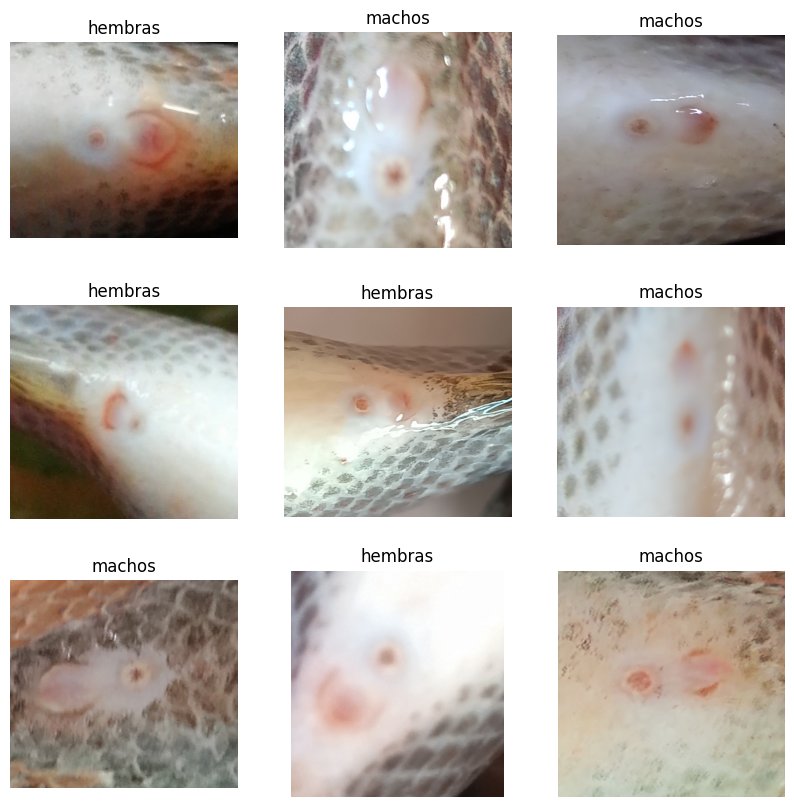

In [31]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(plt.imread(img_df.PATH[i]))
  plt.title(img_df.LABELS[i])
  plt.axis("off")

In [32]:
histories = []
pre_trained_model = VGG16(input_shape=[64, 64, 3], include_top=False, weights="imagenet")

for layer in pre_trained_model.layers[:15]:
  layer.trainable = False

for layer in pre_trained_model.layers[15:]:
  layer.trainable = True

last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output

x = GlobalMaxPooling2D()(last_output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

adam = Adam(learning_rate=0.0005)

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=10) 

for f, (trn_ind, val_ind) in enumerate(kfold.split(img_df,img_labels)):
  print(); print("#"*50)
  print("Fold: ",f+1)
  print("#"*50)
  print(len(trn_ind))
  print(len(val_ind))
  train_ds = datagen.flow_from_dataframe(img_df.loc[trn_ind,:], 
  x_col='PATH', y_col='LABELS',
  target_size=(64, 64),
  batch_size=32,
  shuffle=True,
  class_mode='binary')
  val_ds = datagen.flow_from_dataframe(img_df.loc[val_ind,:], 
    x_col='PATH', y_col='LABELS',
    target_size=(64,64),
    batch_size=32,  
    shuffle=True,
    class_mode='binary')



  history = model.fit(x=train_ds, validation_data=val_ds, epochs=15)

  name = model.evaluate(test_set)[1]
  model_json = model.to_json()
  with open(str(f) + str(name) + ".json", "w") as json_file:
    json_file.write(model_json)
  model.save_weights(str(f) + str(name) + ".h5")
  print("Saved model to disk")

  # store history for each folds
  histories.append(history)


##################################################
Fold:  1
##################################################
2799
311
Found 2799 validated image filenames belonging to 2 classes.
Found 311 validated image filenames belonging to 2 classes.
Epoch 1/15
88/88 [==============================] - 60s 616ms/step - loss: 0.4844 - accuracy: 0.7685 - val_loss: 0.3461 - val_accuracy: 0.8424
Epoch 2/15
88/88 [==============================] - 42s 476ms/step - loss: 0.3582 - accuracy: 0.8396 - val_loss: 0.2871 - val_accuracy: 0.8650
Epoch 3/15
88/88 [==============================] - 42s 476ms/step - loss: 0.3182 - accuracy: 0.8560 - val_loss: 0.2719 - val_accuracy: 0.8907
Epoch 4/15
88/88 [==============================] - 40s 458ms/step - loss: 0.2852 - accuracy: 0.8742 - val_loss: 0.2826 - val_accuracy: 0.8907
Epoch 5/15
88/88 [==============================] - 41s 463ms/step - loss: 0.2602 - accuracy: 0.8878 - val_loss: 0.2732 - val_accuracy: 0.8778
Epoch 6/15
88/88 [=========================

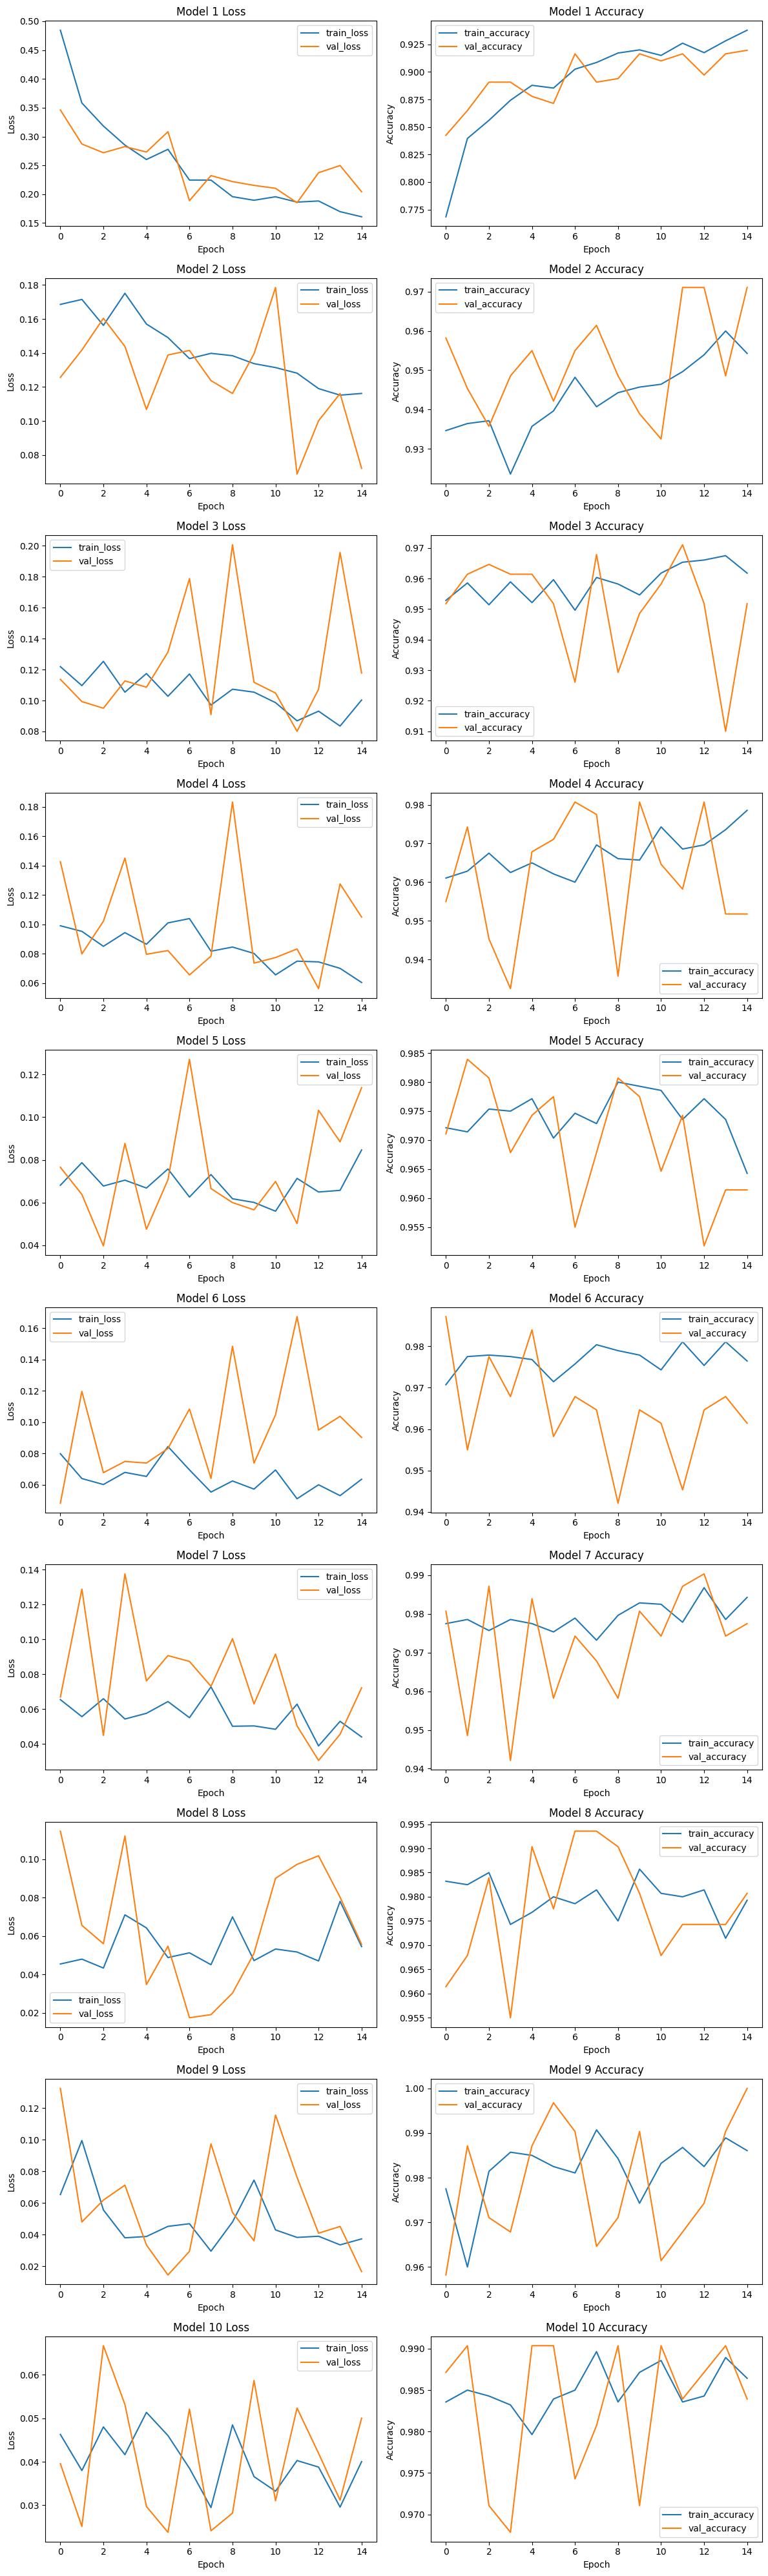

In [33]:
fig, axes = plt.subplots(nrows=len(histories), ncols=2, figsize=(12, len(histories) * 4))

# Iterar a través de las historias de los modelos
for i, history in enumerate(histories):
    # Subgráfica de precisión
    axes[i, 1].plot(history.history['accuracy'], label='train_accuracy')
    axes[i, 1].plot(history.history['val_accuracy'], label='val_accuracy')
    axes[i, 1].set_title(f'Model {i + 1} Accuracy')
    axes[i, 1].set_xlabel('Epoch')
    axes[i, 1].set_ylabel('Accuracy')
    axes[i, 1].legend()


    # Subgráfica de pérdida
    axes[i, 0].plot(history.history['loss'], label='train_loss')
    axes[i, 0].plot(history.history['val_loss'], label='val_loss')
    axes[i, 0].set_title(f'Model {i + 1} Loss')
    axes[i, 0].set_xlabel('Epoch')
    axes[i, 0].set_ylabel('Loss')
    axes[i, 0].legend()

# Ajustar el diseño de las subgráficas
plt.tight_layout()

# Mostrar las gráficas
plt.show()


In [34]:
#Print two classes.
print(list(test_set.class_indices.keys()))
classes = list(test_set.class_indices.keys())
hembras = classes[0]
machos = classes[1]

['hembras', 'machos']


Resultados del fold 1
Modelo del archivo: 00.93750
Loaded model from disk
Modelo con precisión en test con hembras: 0.9083333333333333
Modelo con precisión en test con machos: 0.9666666666666667
Accuracy general del modelo: 0.9375


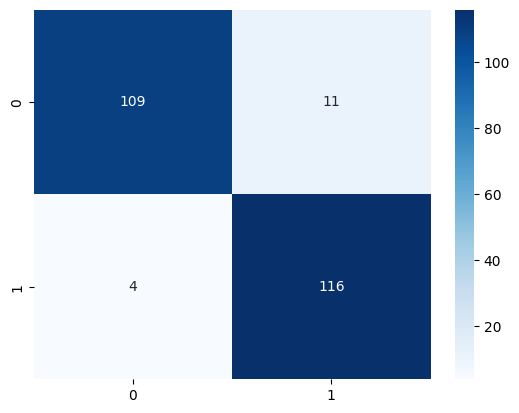

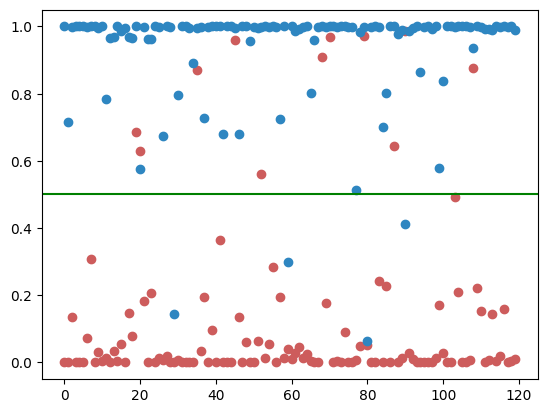

              precision    recall  f1-score   support

           0       0.96      0.91      0.94       120
           1       0.91      0.97      0.94       120

    accuracy                           0.94       240
   macro avg       0.94      0.94      0.94       240
weighted avg       0.94      0.94      0.94       240



Resultados del fold 2
Modelo del archivo: 10.9291666746139526
Loaded model from disk
Modelo con precisión en test con hembras: 0.975
Modelo con precisión en test con machos: 0.8833333333333333
Accuracy general del modelo: 0.9291666666666667


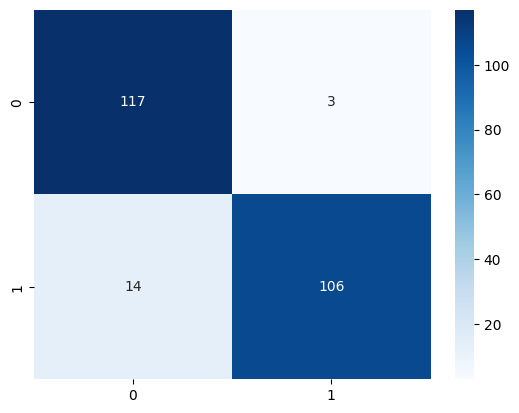

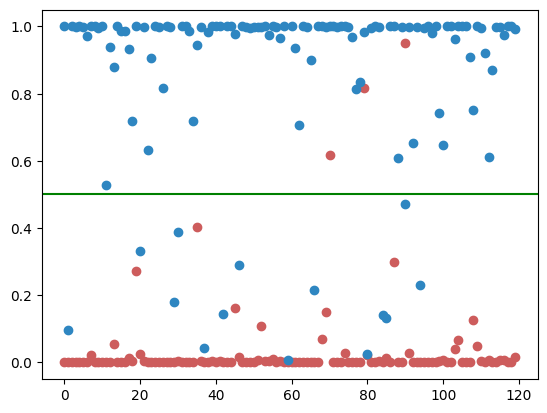

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       120
           1       0.97      0.88      0.93       120

    accuracy                           0.93       240
   macro avg       0.93      0.93      0.93       240
weighted avg       0.93      0.93      0.93       240



Resultados del fold 3
Modelo del archivo: 20.9208333492279053
Loaded model from disk
Modelo con precisión en test con hembras: 0.9333333333333333
Modelo con precisión en test con machos: 0.9083333333333333
Accuracy general del modelo: 0.9208333333333334


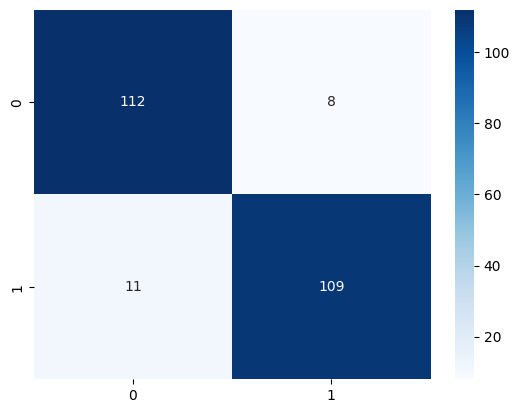

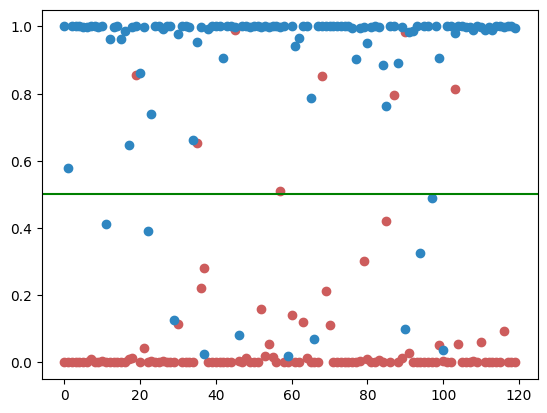

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       120
           1       0.93      0.91      0.92       120

    accuracy                           0.92       240
   macro avg       0.92      0.92      0.92       240
weighted avg       0.92      0.92      0.92       240



Resultados del fold 4
Modelo del archivo: 30.9458333253860474
Loaded model from disk
Modelo con precisión en test con hembras: 0.9416666666666667
Modelo con precisión en test con machos: 0.95
Accuracy general del modelo: 0.9458333333333333


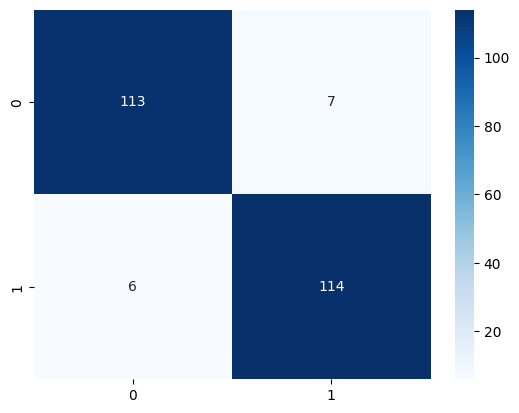

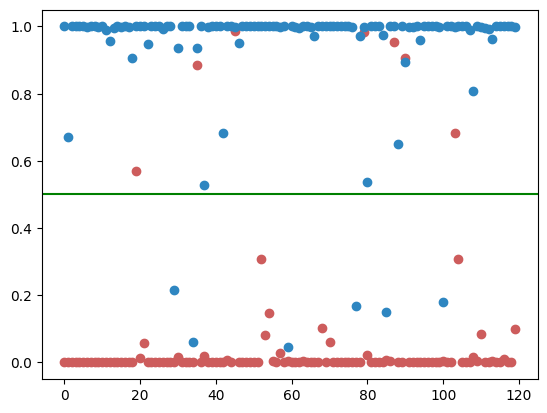

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       120
           1       0.94      0.95      0.95       120

    accuracy                           0.95       240
   macro avg       0.95      0.95      0.95       240
weighted avg       0.95      0.95      0.95       240



Resultados del fold 5
Modelo del archivo: 40.9416666626930237
Loaded model from disk
Modelo con precisión en test con hembras: 0.975
Modelo con precisión en test con machos: 0.9083333333333333
Accuracy general del modelo: 0.9416666666666667


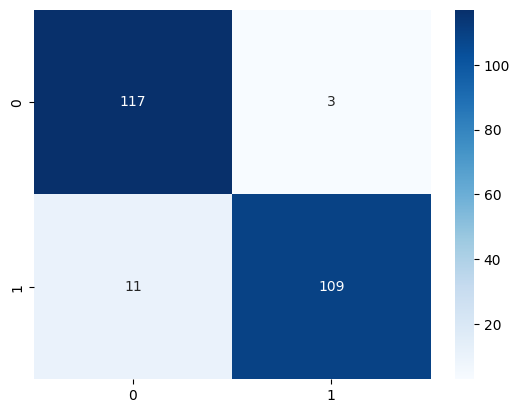

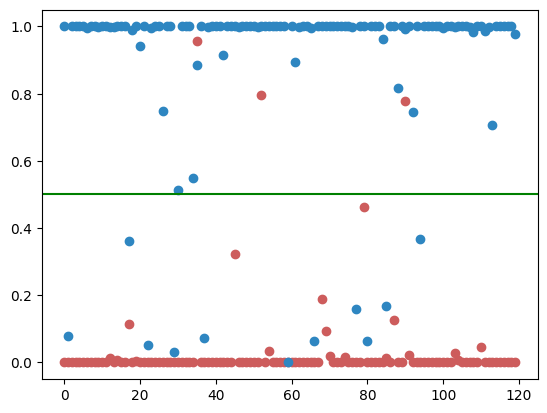

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       120
           1       0.97      0.91      0.94       120

    accuracy                           0.94       240
   macro avg       0.94      0.94      0.94       240
weighted avg       0.94      0.94      0.94       240



Resultados del fold 6
Modelo del archivo: 50.9583333134651184
Loaded model from disk
Modelo con precisión en test con hembras: 0.9416666666666667
Modelo con precisión en test con machos: 0.975
Accuracy general del modelo: 0.9583333333333333


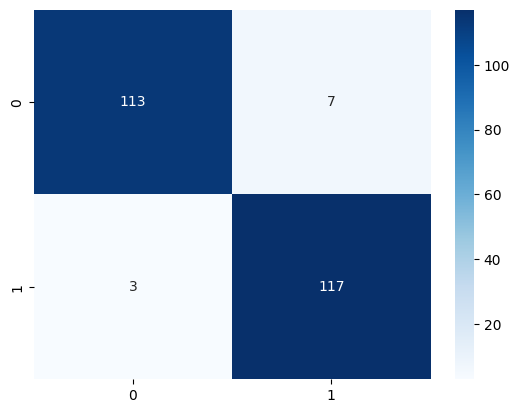

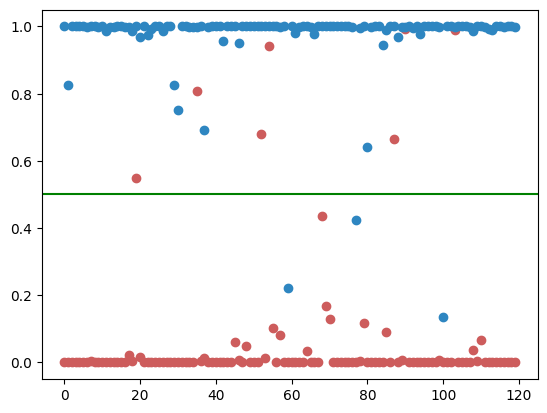

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       120
           1       0.94      0.97      0.96       120

    accuracy                           0.96       240
   macro avg       0.96      0.96      0.96       240
weighted avg       0.96      0.96      0.96       240



Resultados del fold 7
Modelo del archivo: 60.9416666626930237
Loaded model from disk
Modelo con precisión en test con hembras: 0.9583333333333334
Modelo con precisión en test con machos: 0.925
Accuracy general del modelo: 0.9416666666666667


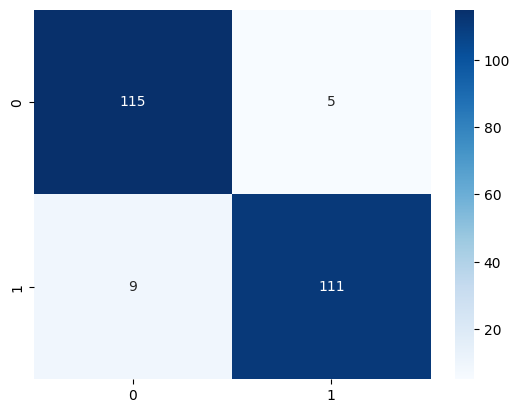

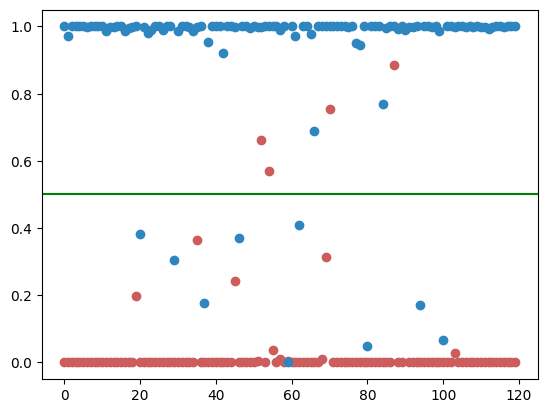

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       120
           1       0.96      0.93      0.94       120

    accuracy                           0.94       240
   macro avg       0.94      0.94      0.94       240
weighted avg       0.94      0.94      0.94       240



Resultados del fold 8
Modelo del archivo: 70.9666666388511658
Loaded model from disk
Modelo con precisión en test con hembras: 0.9583333333333334
Modelo con precisión en test con machos: 0.975
Accuracy general del modelo: 0.9666666666666667


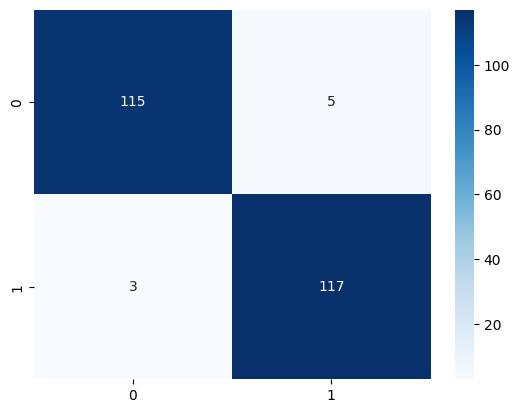

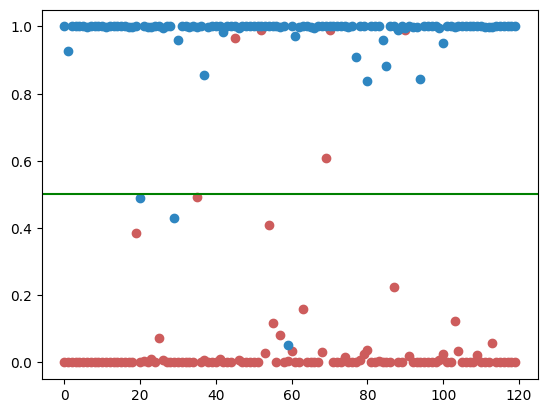

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       120
           1       0.96      0.97      0.97       120

    accuracy                           0.97       240
   macro avg       0.97      0.97      0.97       240
weighted avg       0.97      0.97      0.97       240



Resultados del fold 9
Modelo del archivo: 80.9833333492279053
Loaded model from disk
Modelo con precisión en test con hembras: 0.9833333333333333
Modelo con precisión en test con machos: 0.9833333333333333
Accuracy general del modelo: 0.9833333333333333


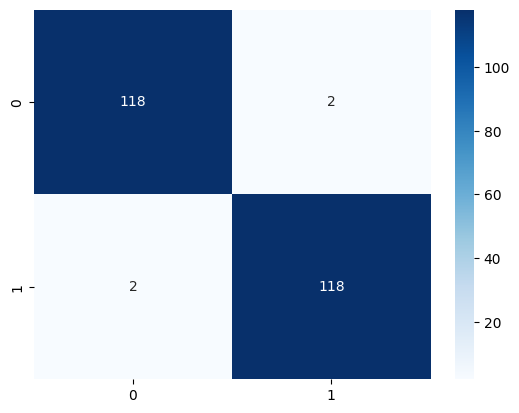

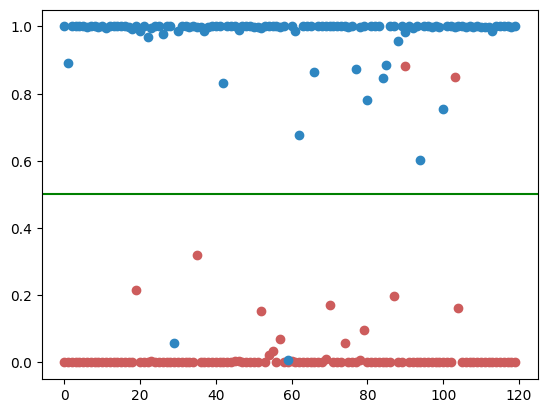

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       120
           1       0.98      0.98      0.98       120

    accuracy                           0.98       240
   macro avg       0.98      0.98      0.98       240
weighted avg       0.98      0.98      0.98       240



Resultados del fold 10
Modelo del archivo: 90.9583333134651184
Loaded model from disk
Modelo con precisión en test con hembras: 0.9833333333333333
Modelo con precisión en test con machos: 0.9333333333333333
Accuracy general del modelo: 0.9583333333333333


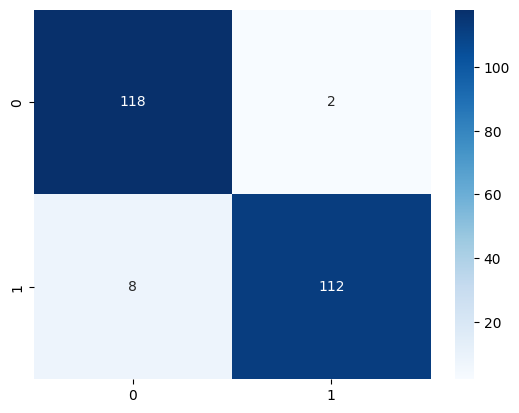

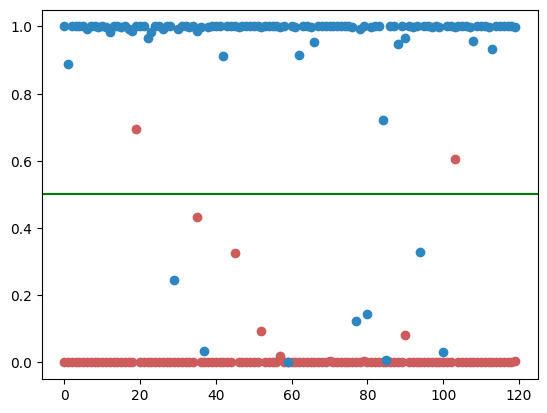

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       120
           1       0.98      0.93      0.96       120

    accuracy                           0.96       240
   macro avg       0.96      0.96      0.96       240
weighted avg       0.96      0.96      0.96       240





In [39]:
import os
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt  

def cargar_y_evaluar_modelos():
    archivos_h5 = [archivo.rstrip('.h5') for archivo in os.listdir() if archivo.endswith('.h5')]
    archivos_h5 = sorted(archivos_h5, key=lambda x: float(x.split('-')[0]))
    
    for i,modelo_archivo in enumerate(archivos_h5):
        print("Resultados del fold " + str(i+1))
        print(f"Modelo del archivo: {modelo_archivo}")
             
        modelo = loadModel(modelo_archivo)
        
        
        accuracyHembras, realValuesHembras, roundedValuesHembras, wrongPathsHembras, wrongErrorsHembras = prediction(model=modelo, pathBatch="../dataset/test_set/hembras", classValue=hembras, classes=test_set.class_indices)      
        accuracyMachos, realValuesMachos, roundedValuesMachos, wrongPathsMachos, wrongErrorsMachos = prediction(model=modelo, pathBatch="../dataset/test_set/machos", classValue=machos, classes=test_set.class_indices)
        
        print(f'Modelo con precisión en test con hembras: {accuracyHembras}')
        print(f'Modelo con precisión en test con machos: {accuracyMachos}')
        
        accuracy_general = (accuracyHembras + accuracyMachos) / 2
        print(f'Accuracy general del modelo: {accuracy_general}')
        
        pred = np.concatenate([roundedValuesHembras, roundedValuesMachos])
        result = confusion_matrix(test_set.classes, pred)
        
        sns.heatmap(result, annot=True, cmap='Blues', fmt='g')
        plt.show()  

        axisXHembras = np.linspace(0,(realValuesHembras.shape[0]-1),realValuesHembras.shape[0])
        axisXMachos  = np.linspace(0,(realValuesMachos.shape[0]-1),realValuesMachos.shape[0])

        plt.scatter(axisXHembras, realValuesHembras, c="#CD5C5C")
        plt.scatter(axisXMachos, realValuesMachos, c="#2E86C1")
        plt.axhline(y=0.5, color='green', linestyle='-')
        plt.show()
        
        print(classification_report(test_set.classes, pred))
        print("\n")

# Llamar a la función
cargar_y_evaluar_modelos()


In [ ]:
ls

0-0.824999988079071.h5     6-0.925000011920929.h5
0-0.824999988079071.json   6-0.925000011920929.json
1-0.8666666746139526.h5    7-0.9333333373069763.h5
1-0.8666666746139526.json  7-0.9333333373069763.json
2-0.8583333492279053.h5    8-0.9375.h5
2-0.8583333492279053.json  8-0.9375.json
3-0.8833333253860474.h5    9-0.9166666865348816.h5
3-0.8833333253860474.json  9-0.9166666865348816.json
4-0.8999999761581421.h5    KFoldStratified.ipynb
4-0.8999999761581421.json  Models/
5-0.9166666865348816.h5    metricas_por_fold/
5-0.9166666865348816.json


In [ ]:
cnn94 = loadModel("0.824999988079071")

Sequential


AttributeError: 'str' object has no attribute 'load_weights'

In [ ]:
for f, (trn_ind, val_ind) in enumerate(kfold.split(img_df,img_labels)):
    print(); print("#"*50)
    print("Fold: ",f+1, " indices")
    print(trn_ind)
    print(val_ind)
    print("#"*50)



##################################################
Fold:  1  indices
[   0    1    2 ... 3107 3108 3109]
[  11   29   49   89  122  137  143  158  162  185  199  205  212  250
  260  285  287  316  329  332  355  360  368  374  392  408  411  420
  445  448  474  559  584  599  602  603  604  607  612  617  624  649
  652  661  662  670  675  695  707  712  718  764  770  784  789  818
  843  878  889  902  908  922  925  927  941  946  950  980  996 1007
 1015 1029 1036 1038 1042 1068 1080 1094 1109 1110 1114 1133 1146 1177
 1178 1181 1193 1230 1244 1250 1259 1261 1280 1290 1314 1326 1329 1331
 1342 1382 1383 1384 1413 1424 1428 1436 1466 1473 1501 1521 1550 1576
 1648 1654 1684 1688 1697 1716 1724 1729 1732 1736 1741 1776 1784 1786
 1794 1795 1799 1804 1818 1837 1840 1849 1865 1880 1882 1904 1910 1921
 1930 1958 1966 1997 2002 2046 2054 2065 2066 2076 2111 2136 2138 2149
 2153 2164 2187 2191 2197 2205 2218 2235 2257 2259 2267 2268 2272 2277
 2282 2285 2286 2328 2330 2336 2347 2386 2

In [37]:
import csv

output_dir = 'metricas_por_fold/'

import os
os.makedirs(output_dir, exist_ok=True)

for fold, history in enumerate(histories):
    model_loss = history.history['loss']  
    val_loss = history.history['val_loss']  
    model_accuracy = history.history['accuracy']  
    val_accuracy = history.history['val_accuracy']  
    
    csv_filename = f'{output_dir}fold_{fold+1}_metrics.csv'
    
    with open(csv_filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Train_Loss', 'Val_Loss', 'Train_Accuracy', 'Val_Accuracy'])
        for epoch in range(len(model_loss)):
            writer.writerow([epoch+1, model_loss[epoch], val_loss[epoch], model_accuracy[epoch], val_accuracy[epoch]])

    print(f"Se ha guardado el archivo CSV para el fold {fold+1} en {csv_filename}")

Se ha guardado el archivo CSV para el fold 1 en metricas_por_fold/fold_1_metrics.csv
Se ha guardado el archivo CSV para el fold 2 en metricas_por_fold/fold_2_metrics.csv
Se ha guardado el archivo CSV para el fold 3 en metricas_por_fold/fold_3_metrics.csv
Se ha guardado el archivo CSV para el fold 4 en metricas_por_fold/fold_4_metrics.csv
Se ha guardado el archivo CSV para el fold 5 en metricas_por_fold/fold_5_metrics.csv
Se ha guardado el archivo CSV para el fold 6 en metricas_por_fold/fold_6_metrics.csv
Se ha guardado el archivo CSV para el fold 7 en metricas_por_fold/fold_7_metrics.csv
Se ha guardado el archivo CSV para el fold 8 en metricas_por_fold/fold_8_metrics.csv
Se ha guardado el archivo CSV para el fold 9 en metricas_por_fold/fold_9_metrics.csv
Se ha guardado el archivo CSV para el fold 10 en metricas_por_fold/fold_10_metrics.csv
